In [32]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Implied Volatility Calculator using Black-Scholes Framework

## Theoretical Foundation

The Black-Scholes model offers a mathematical approach for pricing European options based on several key assumptions:
- Underlying asset prices exhibit log-normal distribution with consistent volatility
- Absence of transaction fees and tax implications  
- Stable risk-free interest rates throughout option lifespan
- No dividend distributions from the underlying stock

### Core Pricing Formula

For call options: 
**C = S₀N(d₁) - Ke^(-rτ)N(d₂)**

Where:
- **C**: Call option premium
- **S₀**: Current underlying asset price
- **K**: Option strike price
- **r**: Annualized risk-free rate
- **τ**: Time until expiration (in years)
- **N(x)**: Standard normal cumulative distribution
- **d₁** = [ln(S₀/K) + (r + σ²/2)τ] / (σ√τ)
- **d₂** = d₁ - σ√τ

### Implied Volatility Concept

Implied volatility represents the market's expectation of future price fluctuations, derived by reverse-engineering the Black-Scholes model to match observed market prices.

In [33]:
def black_scholes_pricing(option_type, spot_price, strike, volatility, time_expiry, interest_rate):
    """
    Calculate European option price using Black-Scholes methodology
    
    Parameters:
    option_type: 'c' for call, 'p' for put
    spot_price: Current underlying price (S₀)
    strike: Option strike price (K)
    volatility: Annualized volatility (σ)
    time_expiry: Time to expiration in years (τ)
    interest_rate: Risk-free rate (r)
    
    Returns:
    option_value: Theoretical option price
    """
    
    # Calculate d1 and d2 parameters
    d1_numerator = np.log(spot_price / strike) + (interest_rate + 0.5 * volatility**2) * time_expiry
    d1_denominator = volatility * np.sqrt(time_expiry)
    d1 = d1_numerator / d1_denominator
    d2 = d1 - volatility * np.sqrt(time_expiry)
    
    # Price calculation based on option type
    if option_type.lower() in ['c', 'call', '1']:
        option_value = (spot_price * stats.norm.cdf(d1) - 
                       strike * np.exp(-interest_rate * time_expiry) * stats.norm.cdf(d2))
    elif option_type.lower() in ['p', 'put', '-1']:
        option_value = (strike * np.exp(-interest_rate * time_expiry) * stats.norm.cdf(-d2) - 
                       spot_price * stats.norm.cdf(-d1))
    else:
        raise ValueError("Option type must be 'c' for call or 'p' for put")
    
    return option_value

In [34]:
def calculate_vega(spot_price, strike, volatility, time_expiry, interest_rate):
    """
    Compute option vega - sensitivity to volatility changes
    
    Vega represents the price change for a 1% change in implied volatility
    """
    d2_numerator = np.log(spot_price / strike) + (interest_rate - 0.5 * volatility**2) * time_expiry
    d2_denominator = volatility * np.sqrt(time_expiry)
    d2 = d2_numerator / d2_denominator
    
    vega = strike * np.exp(-interest_rate * time_expiry) * stats.norm.pdf(d2) * np.sqrt(time_expiry)
    return vega

In [35]:
def compute_implied_volatility(option_type, spot_price, strike, initial_vol, time_expiry, interest_rate, market_price):
    """
    Determine implied volatility using Newton-Raphson root finding
    
    Iteratively adjusts volatility until theoretical price converges with market price
    
    Parameters:
    option_type: 'c' for call, 'p' for put
    spot_price: Current underlying asset price
    strike: Option strike price
    initial_vol: Starting volatility estimate
    time_expiry: Time to expiration in years
    interest_rate: Risk-free interest rate
    market_price: Observed market price of the option
    
    Returns:
    implied_volatility: Calculated implied volatility
    """
    
    current_vol = initial_vol
    tolerance = 1e-10
    iteration_count = 0
    max_iterations = 100
    price_difference = float('inf')
    
    print("Beginning implied volatility calculation...")
    print(f"Target market price: ${market_price:.4f}")
    print("-" * 60)
    
    while abs(price_difference) > tolerance and iteration_count < max_iterations:
        # Calculate current theoretical price and vega
        current_price = black_scholes_pricing(option_type, spot_price, strike, current_vol, 
                                            time_expiry, interest_rate)
        current_vega = calculate_vega(spot_price, strike, current_vol, time_expiry, interest_rate)
        
        price_difference = current_price - market_price
        
        # Avoid division by zero in vega
        if abs(current_vega) < 1e-12:
            print("Warning: Vega approaching zero, adjusting step size")
            current_vol += 0.01  # Small adjustment
            continue
        
        # Newton-Raphson update: σ_new = σ_old - f(σ)/f'(σ)
        vol_adjustment = price_difference / current_vega
        current_vol = current_vol - vol_adjustment
        
        # Ensure volatility stays within reasonable bounds
        if current_vol < 0.001:
            current_vol = 0.001  # Minimum 0.1% volatility
        elif current_vol > 5.0:
            current_vol = 5.0    # Maximum 500% volatility
            
        iteration_count += 1
        
        print(f'Iteration {iteration_count:2d}: σ = {current_vol:.6f}, '
              f'Price Error = ${price_difference:+.2e}')
    
    # Convergence check
    if iteration_count == max_iterations:
        print("⚠ Warning: Maximum iterations reached without full convergence")
    else:
        print(f"✓ Convergence achieved after {iteration_count} iterations")
    
    print("-" * 60)
    return current_vol

In [36]:
# Market parameters configuration
market_option_price = 2.00    # Observed market price
strike_price = 120            # Option strike
time_to_maturity = 1.0        # Years until expiration
risk_free_rate = 0.05         # Annual risk-free rate
current_spot = 100            # Current underlying price
volatility_guess = 0.25       # Initial volatility estimate
option_kind = "c"             # Option type: 'c' for call, 'p' for put

print("Market Data Summary:")
print(f"Option Type: {'Call' if option_kind.lower() == 'c' else 'Put'}")
print(f"Spot Price: ${current_spot}")
print(f"Strike Price: ${strike_price}")
print(f"Market Price: ${market_option_price}")
print(f"Time to Expiry: {time_to_maturity} years")
print(f"Risk-Free Rate: {risk_free_rate:.1%}")

Market Data Summary:
Option Type: Call
Spot Price: $100
Strike Price: $120
Market Price: $2.0
Time to Expiry: 1.0 years
Risk-Free Rate: 5.0%


In [37]:
# Market parameters configuration
market_option_price = 2.00    # Observed market price
strike_price = 120            # Option strike
time_to_maturity = 1.0        # Years until expiration
risk_free_rate = 0.05         # Annual risk-free rate
current_spot = 100            # Current underlying price
volatility_guess = 0.25       # Initial volatility estimate
option_kind = "c"             # Option type: 'c' for call, 'p' for put

print("Market Data Summary:")
print(f"Option Type: {'Call' if option_kind.lower() == 'c' else 'Put'}")
print(f"Spot Price: ${current_spot}")
print(f"Strike Price: ${strike_price}")
print(f"Market Price: ${market_option_price}")
print(f"Time to Expiry: {time_to_maturity} years")
print(f"Risk-Free Rate: {risk_free_rate:.1%}")

Market Data Summary:
Option Type: Call
Spot Price: $100
Strike Price: $120
Market Price: $2.0
Time to Expiry: 1.0 years
Risk-Free Rate: 5.0%


In [38]:
# Compute implied volatility
implied_vol = compute_implied_volatility(
    option_kind, current_spot, strike_price, volatility_guess, 
    time_to_maturity, risk_free_rate, market_option_price
)

# Display results
results_message = f"""
IMPLIED VOLATILITY RESULTS:
----------------------------
Market Option Price: ${market_option_price}
Strike Price: ${strike_price}
Spot Price: ${current_spot}
Time to Expiry: {time_to_maturity} years
Risk-Free Rate: {risk_free_rate:.1%}

Calculated Implied Volatility: {implied_vol:.4f} ({implied_vol:.2%})
"""
print(results_message)

Beginning implied volatility calculation...
Target market price: $2.0000
------------------------------------------------------------
Iteration  1: σ = 0.167706, Price Error = $+3.03e+00
Iteration  2: σ = 0.161556, Price Error = $+1.91e-01
Iteration  3: σ = 0.161483, Price Error = $+2.23e-03
Iteration  4: σ = 0.161483, Price Error = $+3.35e-07
Iteration  5: σ = 0.161483, Price Error = $+0.00e+00
✓ Convergence achieved after 5 iterations
------------------------------------------------------------

IMPLIED VOLATILITY RESULTS:
----------------------------
Market Option Price: $2.0
Strike Price: $120
Spot Price: $100
Time to Expiry: 1.0 years
Risk-Free Rate: 5.0%

Calculated Implied Volatility: 0.1615 (16.15%)



In [39]:
# Verify results by pricing option with calculated implied volatility
validation_price = black_scholes_pricing(
    option_kind, current_spot, strike_price, implied_vol, 
    time_to_maturity, risk_free_rate
)

print("VALIDATION CHECK:")
print(f"Theoretical price using {implied_vol:.4f} volatility: ${validation_price:.6f}")
print(f"Market price: ${market_option_price:.6f}")
print(f"Price difference: ${abs(validation_price - market_option_price):.2e}")

if abs(validation_price - market_option_price) < 1e-8:
    print("✓ Success: Calculated volatility accurately reproduces market price")
else:
    print("⚠ Warning: Price validation failed")

VALIDATION CHECK:
Theoretical price using 0.1615 volatility: $2.000000
Market price: $2.000000
Price difference: $0.00e+00
✓ Success: Calculated volatility accurately reproduces market price



SENSITIVITY ANALYSIS:
Market Price → Implied Volatility
----------------------------------------
Beginning implied volatility calculation...
Target market price: $1.5000
------------------------------------------------------------
Iteration  1: σ = 0.154106, Price Error = $+3.53e+00
Iteration  2: σ = 0.144597, Price Error = $+2.80e-01
Iteration  3: σ = 0.144360, Price Error = $+6.62e-03
Iteration  4: σ = 0.144360, Price Error = $+4.51e-06
Iteration  5: σ = 0.144360, Price Error = $+2.11e-12
✓ Convergence achieved after 5 iterations
------------------------------------------------------------
$ 1.50 →  0.1444 (14.44%)
Beginning implied volatility calculation...
Target market price: $2.0000
------------------------------------------------------------
Iteration  1: σ = 0.167706, Price Error = $+3.03e+00
Iteration  2: σ = 0.161556, Price Error = $+1.91e-01
Iteration  3: σ = 0.161483, Price Error = $+2.23e-03
Iteration  4: σ = 0.161483, Price Error = $+3.35e-07
Iteration  5: σ = 0.161483, 

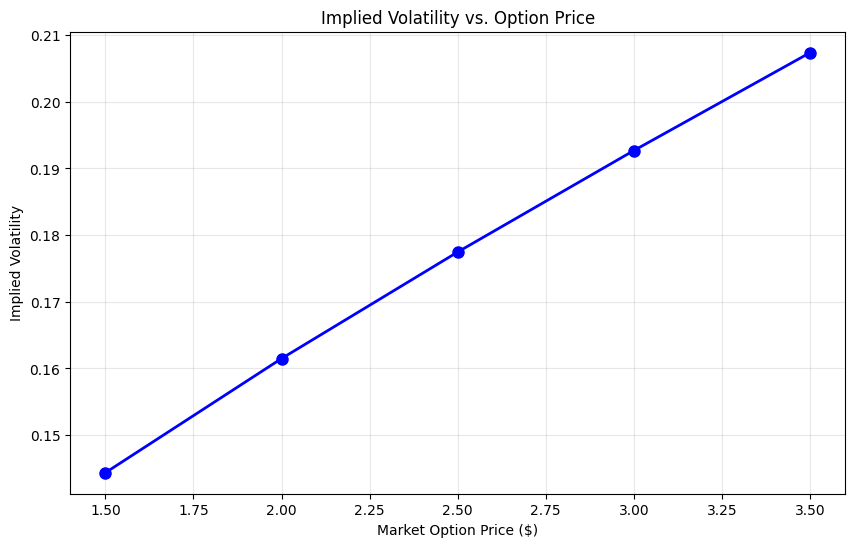

In [40]:
# Analyze how implied volatility changes with different market prices
market_prices_test = [1.5, 2.0, 2.5, 3.0, 3.5]
implied_vols = []

print("\nSENSITIVITY ANALYSIS:")
print("Market Price → Implied Volatility")
print("-" * 40)

for price in market_prices_test:
    iv = compute_implied_volatility(
        option_kind, current_spot, strike_price, volatility_guess,
        time_to_maturity, risk_free_rate, price
    )
    implied_vols.append(iv)
    print(f"${price:5.2f} → {iv:7.4f} ({iv:6.2%})")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(market_prices_test, implied_vols, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Market Option Price ($)')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs. Option Price')
plt.grid(True, alpha=0.3)
plt.show()